## Trying a new approach to inhibit time 

### previously I had binned all time into n seconds intervals and asked within this interval is this inhibited or not in a binary fashion. With some more exploration, what we might really want is to ask more about fraction inhibited so moved to try this piece-wise approach

below is some code from chat that I arrived at after walkihg throguh the logic that I would like implemented basically it is defining intervals of inhibition and active time using a step wise t-1, t-1 + inhibit to get the intervals. It then stores the boundaries of all these times in either active or inhibit counts and can compute from there what the proportion of each run is active across these boundaries


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List, Tuple


# ----------------------------
# 1) Load all ADC-only CSVs
# ----------------------------
def collect_adc_csvs(data_dir: str, pattern: str = "*.csv", max_files: Optional[int] = None):
    data_path = Path(data_dir)
    files = sorted(data_path.rglob(pattern))
    if max_files:
        files = files[:max_files]
    return files


def load_adc_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    required = {"RunTime", "InhibitTimeDiff"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{path.name}: missing columns {missing}")

    df["RunTime"] = pd.to_numeric(df["RunTime"], errors="coerce")
    df["InhibitTimeDiff"] = pd.to_numeric(df["InhibitTimeDiff"], errors="coerce")

    df = df.dropna(subset=["RunTime", "InhibitTimeDiff"]).sort_values("RunTime").reset_index(drop=True)
    if len(df) < 2:
        raise ValueError(f"{path.name}: too few rows after cleaning")

    return df


# -----------------------------------------
# 2) Build inhibit intervals for one run
# -----------------------------------------
def inhibit_intervals_from_df(df: pd.DataFrame, abs_tol: float = 1e-6):
    """
    Uses your convention:
      - RunTime is the event/capture time
      - InhibitTimeDiff is the dead time following the previous capture,
        stored on the NEXT row (as in your example file).

    For i = 1..N-1:
      start = RunTime[i-1]
      dt    = RunTime[i] - RunTime[i-1]
      di    = InhibitTimeDiff[i]  (clamped to [0, dt])

    Produces inhibit intervals: [start, start + di]
    Returns normalized times (seconds since run start):
      t0=0, t_end, starts[], ends[]
    """
    t = df["RunTime"].to_numpy(dtype=float)
    dI = df["InhibitTimeDiff"].to_numpy(dtype=float)

    # normalize time to run start
    t0 = float(t[0])
    t = t - t0

    dt = np.diff(t)          # length N-1
    di = dI[1:]              # align with transitions; length N-1

    # clean/clamp
    di = np.where(np.isfinite(di), di, 0.0)
    dt = np.where(np.isfinite(dt), dt, 0.0)
    dt = np.where(dt < 0, 0.0, dt)
    di = np.where(di > abs_tol, di, 0.0)
    di = np.clip(di, 0.0, dt)

    starts = t[:-1]
    ends = starts + di

    m = ends > starts
    starts = starts[m]
    ends = ends[m]

    t_end = float(t[-1])
    return 0.0, t_end, starts, ends


# -----------------------------------------------------
# 3) Aggregate across runs (piecewise-constant p(T))
# -----------------------------------------------------
def piecewise_probability_inhibited(
    csv_paths: List[Path],
    abs_tol: float = 1e-6
) -> pd.DataFrame:
    """
    Returns pw_df with constant counts on intervals [t_start, t_end):
      active = # runs still ongoing at time T
      inhib  = # runs inhibited at time T
      p_inhib = inhib/active
    """
    if not csv_paths:
        return pd.DataFrame(columns=["t_start", "t_end", "active", "inhib", "p_inhib"])

    active_events = []  # (time, delta)
    inhib_events = []   # (time, delta)

    for path in csv_paths:
        try:
            df = load_adc_csv(path)
            t0, t_end, s, e = inhibit_intervals_from_df(df, abs_tol=abs_tol)

            # active coverage for this run
            active_events.append((t0, +1))
            active_events.append((t_end, -1))

            # inhibit intervals
            for a, b in zip(s, e):
                inhib_events.append((float(a), +1))
                inhib_events.append((float(b), -1))

        except Exception as exc:
            print(f"Skipping {path.name}: {exc}")

    if not active_events:
        return pd.DataFrame(columns=["t_start", "t_end", "active", "inhib", "p_inhib"])

    # Build event series and cumulative sums at change points
    ae = pd.DataFrame(active_events, columns=["time", "delta"]).groupby("time", as_index=False)["delta"].sum()
    ie = pd.DataFrame(inhib_events,  columns=["time", "delta"]).groupby("time", as_index=False)["delta"].sum()

    # Union of change points
    times = np.array(sorted(set(ae["time"]).union(set(ie["time"]))), dtype=float)
    if len(times) < 2:
        return pd.DataFrame(columns=["t_start", "t_end", "active", "inhib", "p_inhib"])

    # Map time -> delta using reindex on full time grid
    ae_map = ae.set_index("time").reindex(times, fill_value=0)["delta"].to_numpy()
    ie_map = ie.set_index("time").reindex(times, fill_value=0)["delta"].to_numpy()

    active = np.cumsum(ae_map)
    inhib = np.cumsum(ie_map)

    # piecewise intervals between successive change points
    t_start = times[:-1]
    t_end = times[1:]
    active_i = active[:-1]
    inhib_i = inhib[:-1]

    # probability conditional on being active
    p = np.divide(inhib_i, active_i, out=np.zeros_like(inhib_i, dtype=float), where=active_i > 0)

    pw_df = pd.DataFrame({
        "t_start": t_start,
        "t_end": t_end,
        "active": active_i,
        "inhib": inhib_i,
        "p_inhib": p
    })

    # drop intervals with no active runs (optional, but usually desirable)
    pw_df = pw_df[pw_df["active"] > 0].reset_index(drop=True)
    return pw_df


# -----------------------------------------------------
# 4) Sample to a regular time grid + smooth + plot
# -----------------------------------------------------
def sample_piecewise(pw_df: pd.DataFrame, dt: float = 1.0) -> pd.DataFrame:
    """
    Convert piecewise constant pw_df into regularly sampled grid_df at step dt seconds.
    """
    if pw_df.empty:
        return pd.DataFrame(columns=["time_s", "p_inhib", "active", "inhib"])

    t_max = float(pw_df["t_end"].max())
    t_grid = np.arange(0, t_max + dt, dt)

    # For each grid point, find the interval containing it (right-open)
    starts = pw_df["t_start"].to_numpy()
    idx = np.searchsorted(starts, t_grid, side="right") - 1
    idx = np.clip(idx, 0, len(pw_df) - 1)

    grid_df = pd.DataFrame({
        "time_s": t_grid,
        "p_inhib": pw_df["p_inhib"].to_numpy()[idx],
        "active": pw_df["active"].to_numpy()[idx],
        "inhib": pw_df["inhib"].to_numpy()[idx],
    })
    return grid_df


def plot_p_inhib(
    grid_df: pd.DataFrame,
    smooth_window_s: float = 60.0,   # strong smoothing (seconds)
    dt: float = 1.0,
    show_raw: bool = True,
    title: str = "P(Inhibited at time T | run active)",
    save_path: Optional[str] = None
):
    if grid_df.empty:
        print("grid_df is empty; nothing to plot.")
        return

    y = grid_df["p_inhib"].to_numpy()
    t = grid_df["time_s"].to_numpy()

    # rolling mean smoothing
    if smooth_window_s and smooth_window_s > 0:
        w = max(1, int(round(smooth_window_s / dt)))
        y_smooth = pd.Series(y).rolling(window=w, center=True, min_periods=1).mean().to_numpy()
    else:
        y_smooth = y

    fig, ax = plt.subplots(figsize=(12, 4))
    if show_raw:
        ax.plot(t, y, linewidth=1.0, alpha=0.25, label="raw (sampled)")
    ax.plot(t, y_smooth, linewidth=2.5, label=f"smoothed ({smooth_window_s}s)")

    ax.set_xlabel("Time since run start (s)")
    ax.set_ylabel("Proportion inhibited (0–1)")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.25)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved figure to: {save_path}")
    plt.show()


# ----------------------------
# 5) One-call convenience
# ----------------------------
def compute_and_plot_probability(
    data_dir: str,
    pattern: str = "*.csv",
    abs_tol: float = 1e-6,
    sample_dt: float = 1.0,
    smooth_window_s: float = 200.0,
    max_files: Optional[int] = None,
    save_path: Optional[str] = None,
    show_raw: bool = True,
    title: str = "P(Inhibited at time T | run active)"
):
    csv_paths = collect_adc_csvs(data_dir, pattern=pattern, max_files=max_files)
    pw_df = piecewise_probability_inhibited(csv_paths, abs_tol=abs_tol)
    grid_df = sample_piecewise(pw_df, dt=sample_dt)

    plot_p_inhib(
        grid_df,
        smooth_window_s=smooth_window_s,
        dt=sample_dt,
        show_raw=show_raw,
        title=title,
        save_path=save_path
    )
    return pw_df, grid_df


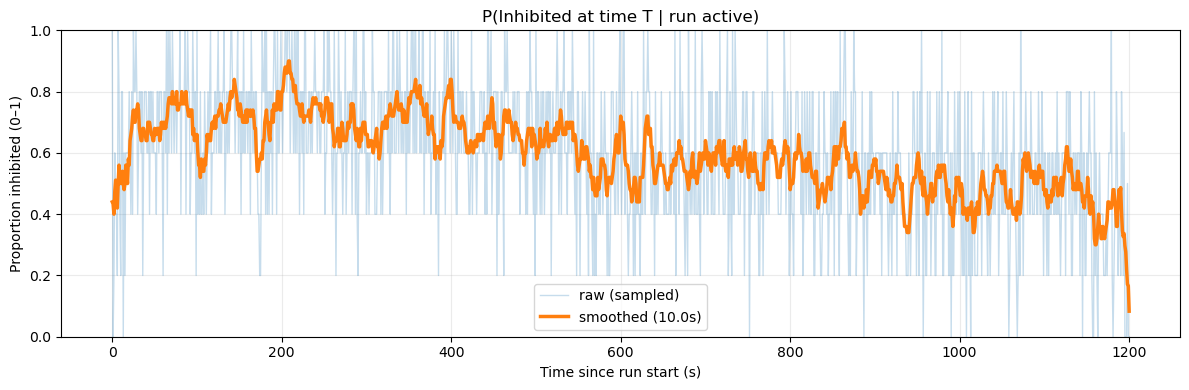

    t_start     t_end  active  inhib  p_inhib
0  0.000000  0.080712       5      5      1.0
1  0.080712  0.080951       5      4      0.8
2  0.080951  0.081450       5      3      0.6
3  0.081450  0.082331       5      2      0.4
4  0.082331  0.311647       5      1      0.2
   time_s  p_inhib  active  inhib
0     0.0      1.0       5      5
1     1.0      0.0       5      0
2     2.0      0.2       5      1
3     3.0      0.6       5      3
4     4.0      0.4       5      2


In [16]:
data_dir = "../IFCBData/AlexandriumTest/merged/"

pw_df, grid_df = compute_and_plot_probability(
    data_dir=data_dir,
    pattern="*merged.csv",   # optional, if you want to target only these
    sample_dt=1.0,              # 1-second sampling for plotting
    smooth_window_s=10.0,      # strong smoothing (e.g., 2 minutes)
    max_files=None,
    #save_path = "../Figs/PropInhibibDenseAlex.png"
)

print(pw_df.head())
print(grid_df.head())
